In [1]:
import pandas as pd
import numpy as np
from keras.models import Model
from keras.layers import (Input, Dense, Dropout, Flatten, Reshape, Conv2D, UpSampling2D, Embedding,
                          BatchNormalization, Flatten, LeakyReLU, AveragePooling2D, GaussianNoise, 
                          Concatenate, Multiply)
from keras.preprocessing.image import array_to_img
from keras.optimizers import Adam, SGD
from keras_preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from PIL import Image
from keras.initializers import TruncatedNormal

Using TensorFlow backend.


In [2]:
def forKaggle1(x):
    y = "../input/train"+x[9:]
    return y

def formatting1(string):
    y = pd.read_csv(string, names=['filename', 'abnormal'])
    y.filename = y.filename.apply(lambda x: forKaggle1(x))
    y.abnormal = y.abnormal.astype('int').astype('str').astype('category')
    return y

In [3]:
elbow_train = formatting1("../input/trainset_elbow.csv")
finger_train = formatting1("../input/trainset_finger.csv")
forearm_train = formatting1("../input/trainset_forearm.csv")
hand_train = formatting1("../input/trainset_hand.csv")
humerus_train = formatting1("../input/trainset_humerus.csv")
shoulder_train = formatting1("../input/trainset_shoulder.csv")
wrist_train = formatting1("../input/trainset_wrist.csv")

In [4]:
small_size = 56
img_size = 224
b_size = 32
channels = 3
latent_dim  = 7000
num_of_classes = 7
np.random.seed(2019)

def train_gen(DATAFRAME):
    train_data_gen = ImageDataGenerator(rescale=1./255)
    train_generator = train_data_gen.flow_from_dataframe(dataframe = DATAFRAME, directory = None,
                                                         target_size=(img_size, img_size), batch_size=b_size,
                                                         shuffle = True, color_mode = 'rgb',
                                                         class_mode = None, drop_duplicates=False)
    return train_generator

In [5]:
images = []
conditions = []

for data in [elbow_train,finger_train,forearm_train,hand_train,humerus_train,shoulder_train,wrist_train]:
    images.append(train_gen(data).next())

for i in range(7):
    onehot = np.zeros(7, dtype='int')
    onehot[i] = 1
    onehots = [onehot for y in range(b_size)]
    conditions.append(onehots)

images = np.array(images)
conditions = np.array(conditions)

del elbow_train,finger_train,forearm_train,hand_train,humerus_train,shoulder_train,wrist_train

Found 4931 validated image filenames.
Found 5106 validated image filenames.
Found 1825 validated image filenames.
Found 5543 validated image filenames.
Found 1272 validated image filenames.
Found 8379 validated image filenames.
Found 9752 validated image filenames.


## Generator

In [6]:
noise_input = Input(shape=(latent_dim,))
c_input = Input(shape=(num_of_classes,))

embedding = Embedding(num_of_classes, 1000)(c_input)
merge_layer = Multiply()([noise_input, Flatten()(embedding)])

x = Dense(28*28*64)(merge_layer)
x = BatchNormalization()(x)
x = LeakyReLU(0.2)(x)
x = Reshape((28,28,64))(x)
x = UpSampling2D()(x)

# 56x56x128
x = Conv2D(64, 5, padding='same')(x)
x = LeakyReLU(0.2)(x)
x = BatchNormalization()(x)
x = UpSampling2D()(x)

# 112x112x64
x = Conv2D(64, 3, padding='same')(x)
x = LeakyReLU(0.2)(x)
x = BatchNormalization()(x)
x = UpSampling2D()(x)

# 224x224x32
x = Conv2D(32, 3, padding='same')(x)
x = LeakyReLU(0.2)(x)
x = BatchNormalization()(x)

generator_output = Conv2D(channels, 3, activation='sigmoid', padding='same')(x)
generator = Model(inputs=[noise_input, c_input], outputs=generator_output)
generator.compile(loss='binary_crossentropy', optimizer=Adam(lr=1e-4, decay=1e-6))

generator.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 7)            0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 7, 1000)      7000        input_2[0][0]                    
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 7000)         0                                            
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 7000)         0           embedding_1[0][0]                
__________________________________________________________________________________________________
multiply_1

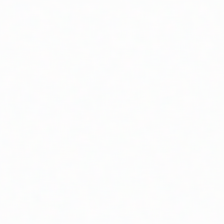

In [7]:
# initial generated image
noise = np.random.normal(0,1,size=latent_dim)
noise = np.reshape(noise, newshape=(1,latent_dim))
onehot = np.array([[0 for i in range(num_of_classes)]])
onehot[0][0] = 1
img = generator.predict([noise, onehot])
img = np.reshape(img, newshape=(img_size,img_size,channels))
array_to_img(img)

## Discriminator

In [8]:
# simple cnn model
discriminator_input = Input(shape=(img_size,img_size,channels))

x = GaussianNoise(0.2)(discriminator_input)
x = Conv2D(64, 5, padding='same', kernel_initializer=TruncatedNormal(stddev=0.02))(x)
x = BatchNormalization(momentum=0.5)(x)
x = LeakyReLU(0.2)(x)
x = AveragePooling2D((2,2))(x)

x = GaussianNoise(0.2)(x)
x = Conv2D(64, 5, padding='same', kernel_initializer=TruncatedNormal(stddev=0.02))(x)
x = BatchNormalization(momentum=0.5)(x)
x = LeakyReLU(0.2)(x)
x = AveragePooling2D((2,2))(x)

x = GaussianNoise(0.2)(x)
x = Conv2D(64, 5, padding='same', kernel_initializer=TruncatedNormal(stddev=0.02))(x)
x = BatchNormalization(momentum=0.5)(x)
x = LeakyReLU(0.2)(x)
x = AveragePooling2D((2,2))(x)

x = Flatten()(x)
x = Dense(3500)(x)
x = LeakyReLU(0.2)(x)
x = Dropout(0.3)(x)
embedding_d = Embedding(num_of_classes, 500)(c_input)
discriminator_merge = Multiply()([x, Flatten()(embedding_d)])
x = Dense(1024)(discriminator_merge)
x = LeakyReLU(0.2)(x)
x = Dropout(0.3)(x)
discriminator_output = Dense(1, activation="sigmoid")(x)

discriminator = Model(inputs=[discriminator_input, c_input], outputs=discriminator_output)
discriminator.trainable = True
discriminator.compile(loss='binary_crossentropy', optimizer=SGD(lr=1e-3,decay=1e-6, momentum=0.9, nesterov=True))
discriminator.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
gaussian_noise_1 (GaussianNoise (None, 224, 224, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 224, 224, 64) 4864        gaussian_noise_1[0][0]           
__________________________________________________________________________________________________
batch_normalization_5 (BatchNor (None, 224, 224, 64) 256         conv2d_5[0][0]                   
__________________________________________________________________________________________________
leaky_re_l

### Pre-Train Discriminator

In [9]:
for epoch in range(20):
    i = int(epoch%7)
    print(discriminator.train_on_batch([images[i], conditions[i]], np.ones(b_size)))
    fakes = generator.predict([np.random.normal(0,1,size=(b_size, latent_dim)), conditions[i]])
    print(discriminator.train_on_batch([fakes, conditions[i]], np.array([0.1 for i in range(b_size)])))

0.698389
0.69478565
0.69882864
0.6886924
0.68698025
0.69875157
0.69174457
0.6980903
0.690088
0.69673485
0.6896158
0.69352496
0.68225074
0.70005316
0.68471247
0.7001033
0.6848049
0.6989279
0.6715783
0.7044735
0.67498237
0.6995653
0.67792547
0.7032788
0.6764717
0.7011303
0.6708559
0.70614827
0.6737151
0.70655096
0.66939235
0.69963294
0.66345406
0.70992076
0.66182005
0.7078882
0.668368
0.7076558
0.66179717
0.705966


### Creating GAN

In [10]:
gan_output = discriminator([generator_output, c_input])
gan = Model(inputs=[noise_input, c_input], outputs=gan_output)
discriminator.trainable = False
gan.compile(loss='binary_crossentropy', optimizer=Adam(lr=1e-4, decay=1e-6))

## Training GAN

In [11]:
def getFakeData(iteration):
    noise = np.random.normal(0,1,size=(b_size,latent_dim))
    onehot = conditions[iteration]
    x_fake = generator.predict([noise, onehot])
    y_fake = np.array([0.1 for i in range(len(x_fake))]) #0.1 to represent fake
    return x_fake, y_fake

def getNoisyData(y_real): # occasionally flip the labels when training the discriminator
    if np.random.random_integers(0,1) == 0:
        return y_real
    else:
        max_flips = len(y_real)//8
        number_of_flips = np.random.randint(0,max_flips)
        for i in np.random.choice([i for i in range(max_flips)], number_of_flips):
            y_real[i] = 0.1
        return y_real
    
def train_discriminator(iteration):
    x_real, y_real = getRealData(iteration)
    x_fake, y_fake = getFakeData(iteration)
    
    # train discriminator
    discriminator.trainable = True
    y_real = getNoisyData(y_real)
    onehot = conditions[iteration]
    loss_real = discriminator.train_on_batch([x_real, onehot], y_real)
    loss_fake = discriminator.train_on_batch([x_fake, onehot], y_fake)
    return [loss_real, loss_fake]
    
def train_gan(iteration):
    # train generator
    discriminator.trainable = False
    noise = np.random.normal(0,1,size=(b_size,latent_dim))
    onehot = conditions[iteration]
    y_gen = np.ones(len(noise))
    g_loss = gan.train_on_batch([noise, onehot], y_gen)
    return g_loss

def getRealData(iteration):
    x_real = images[iteration]
    y_real = np.array([(0.8+0.01*iteration) for i in range(len(x_real))]) # label smoothing
    return x_real, y_real

In [12]:
epoch = 1
while (epoch<=3000):
    for i in range(7):
        loss_real, loss_fake = train_discriminator(i)
        g_loss = train_gan(i)
    if epoch%5 == 0:
        print("Epoch ", epoch)
        print("Discriminator Loss (Real):", loss_real)
        print("Discriminator Loss (Fake):", loss_fake)
        d_loss = 0.5*(loss_real+loss_fake)
        print("Discriminator Loss (Total):", d_loss)
        print("Gen Loss:", g_loss)
    epoch+=1

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: This function is deprecated. Please call randint(0, 1 + 1) instead
  if __name__ == '__main__':


Epoch  5
Discriminator Loss (Real): 0.68577504
Discriminator Loss (Fake): 0.67503315
Discriminator Loss (Total): 0.6804040670394897
Gen Loss: 0.7227042
Epoch  10
Discriminator Loss (Real): 0.7074454
Discriminator Loss (Fake): 0.65305126
Discriminator Loss (Total): 0.6802483201026917
Gen Loss: 0.75163376
Epoch  15
Discriminator Loss (Real): 0.7226186
Discriminator Loss (Fake): 0.6460743
Discriminator Loss (Total): 0.6843464374542236
Gen Loss: 0.75300145
Epoch  20
Discriminator Loss (Real): 0.7566698
Discriminator Loss (Fake): 0.61537224
Discriminator Loss (Total): 0.6860210299491882
Gen Loss: 0.7981324
Epoch  25
Discriminator Loss (Real): 0.7536581
Discriminator Loss (Fake): 0.60100985
Discriminator Loss (Total): 0.6773339509963989
Gen Loss: 0.8273231
Epoch  30
Discriminator Loss (Real): 0.7468212
Discriminator Loss (Fake): 0.60125494
Discriminator Loss (Total): 0.6740380525588989
Gen Loss: 0.8239068
Epoch  35
Discriminator Loss (Real): 0.7352512
Discriminator Loss (Fake): 0.6119714
Dis

In [13]:
def plotImage(condition):
    noise = np.random.normal(0,1,size=latent_dim)
    noise = np.reshape(noise, newshape=(1,latent_dim))
    onehot = np.array([[0 for i in range(num_of_classes)]])
    onehot[0][condition] = 1
    image = generator.predict([noise, onehot])
    image = np.reshape(image, newshape=(img_size,img_size,channels))
    image = array_to_img(image)
    return image

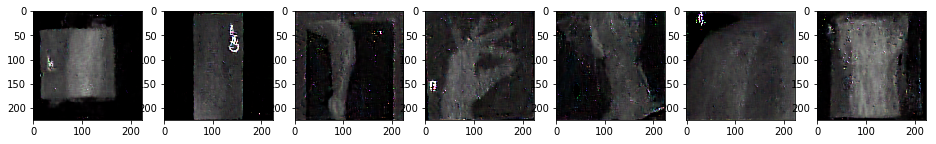

In [14]:
fig=plt.figure(figsize=(16, 16))
for i in range(1, 8):
    img = plotImage(i-1)
    fig.add_subplot(1, 7, i)
    plt.imshow(img)
plt.show()